In [1]:
%matplotlib notebook

<IPython.core.display.Javascript object>


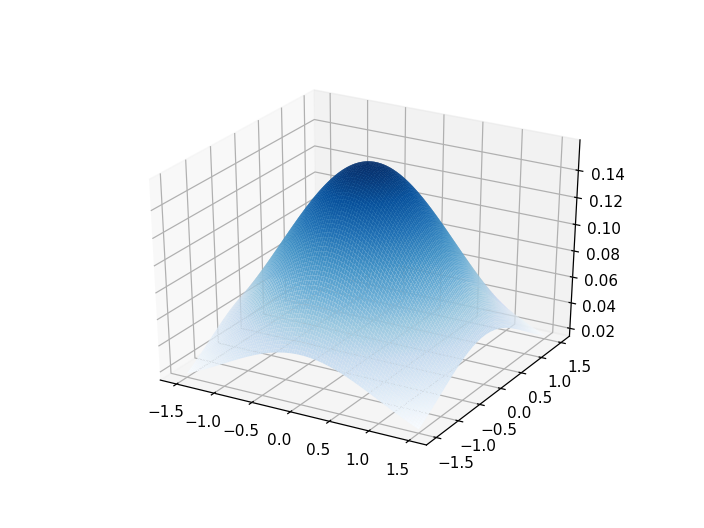

In [11]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.linspace(-1.5, 1.5, 100)
Y = np.linspace(-1.5, 1.5, 100)
X, Y = np.meshgrid(X, Y)

Z = np.zeros_like(X)
Z[X**2 + Y**2 < 1] = 1/2

Z = np.exp(-(X**2 + Y**2) / 2) / (2 * np.pi)
#R = np.sqrt(X**2 + Y**2)
#Z = np.sin(R * 4)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.Blues,
                       linewidth=0, antialiased=True, alpha=None, rstride=1, cstride=1)


#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])


# plt.show()

<IPython.core.display.Javascript object>


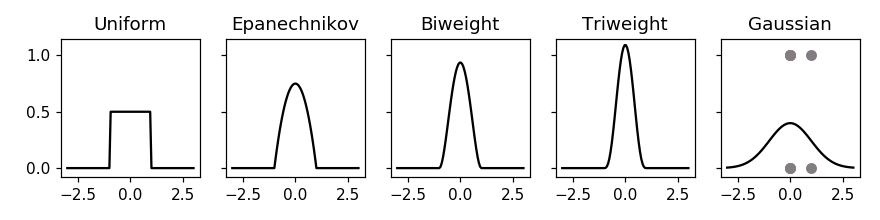

In [34]:

x = np.linspace(-3, 3, 100)
ys = [
    1/2 * (np.abs(x) < 1),
    3/4 * (1 - x**2) * (np.abs(x) < 1),
    15/16 * (1 - x**2)**2 * (np.abs(x) < 1),
    35/32 * (1 - x**2)**3 * (np.abs(x) < 1),
    np.exp(-x**2 / 2) / np.sqrt(2 * np.pi),
]
names = [
    'Uniform',
    'Epanechnikov',
    'Biweight',
    'Triweight',
    'Gaussian',
]

fig, axes = plt.subplots(ncols=len(ys), figsize=(8, 2), sharey=True)
for (ax, y, name) in zip(axes, ys, names):
    ax.plot(x, y, 'k', label=name)
    ax.set_title(name)


fig.tight_layout()
plt.show()

In [196]:
def generate_moons_3d(n_samples=200, noise=0.1):
    t = np.linspace(0, 1, n_samples)
    # t = (t - 0.5) / 4 + 3 * (t - 0.5)**3 + 1/2
    t = np.arccos(1 - 2 * t) / np.pi
    x = np.cos(t * np.pi)
    y = np.sin(t * np.pi)
    z = np.zeros(n_samples)
    i = 1 - np.linspace(-1, 1, n_samples) ** 2

    X = np.vstack([
        np.vstack([x, y, z]).T,
        np.vstack([x + 4/3, -y, z]).T,
        np.vstack([z - 1/3, -y, x]).T
    ])
    y = np.hstack([
        0 * np.ones(n_samples),
        1 * np.ones(n_samples),
        2 * np.ones(n_samples)
    ])
    scale = np.hstack([i] * 3)
    scale = np.vstack([scale] * 3).T

    if noise is not None:
        X += scale * np.random.normal(scale=0.1, size=X.shape)
    
    return X, y

<IPython.core.display.Javascript object>


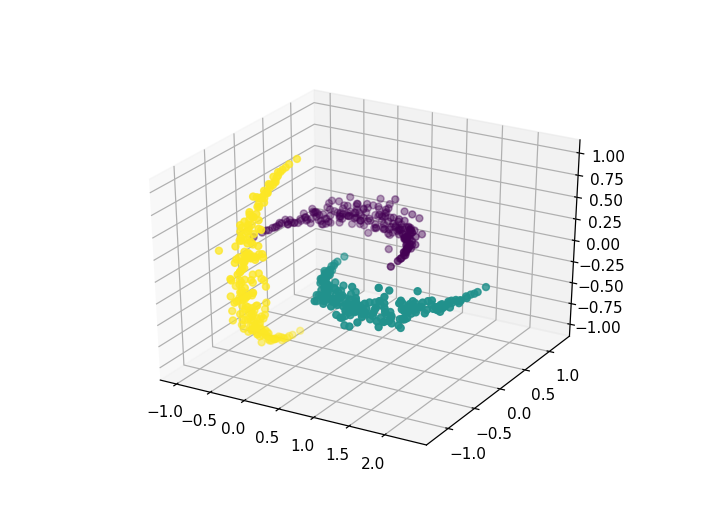

In [197]:
X, y = generate_moons_3d()

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)
plt.show()

In [144]:
from sklearn.neighbors import KernelDensity
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift


#bandwidth = estimate_bandwidth(X)
ms = MeanShift(0.5)
y_pred = ms.fit_predict(X)
y_pred.max()

9

<IPython.core.display.Javascript object>


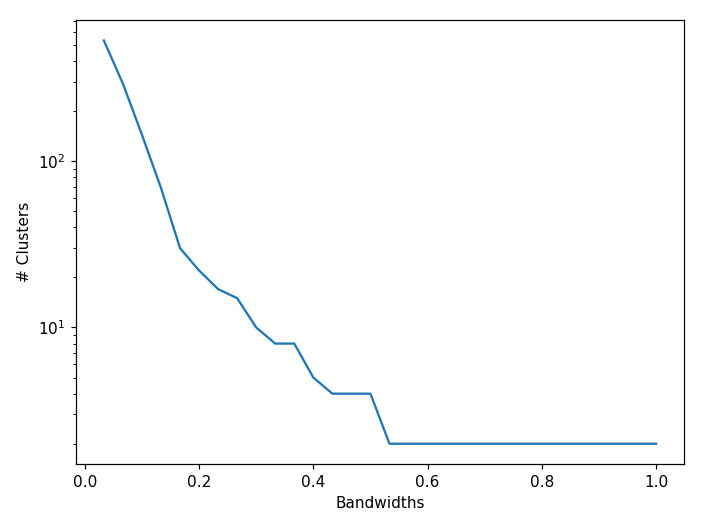

In [203]:
def plot_bandwidth_profile(X, n_bandwidths=30):
    bandwidths = np.linspace(1 / n_bandwidths, 1, n_bandwidths)

    Ks = np.array([MeanShift(bandwidth).fit_predict(X).max() for bandwidth in bandwidths])

    fig, ax = plt.subplots()
    ax.plot(bandwidths, Ks)
    
    ax.set_xlabel('Bandwidths')
    ax.set_ylabel('# Clusters')
    # ax.set_yscale("log", nonposy='clip')

    fig.tight_layout()    
    return fig, ax

fig, ax = plot_bandwidth_profile(X)
plt.show()

<IPython.core.display.Javascript object>


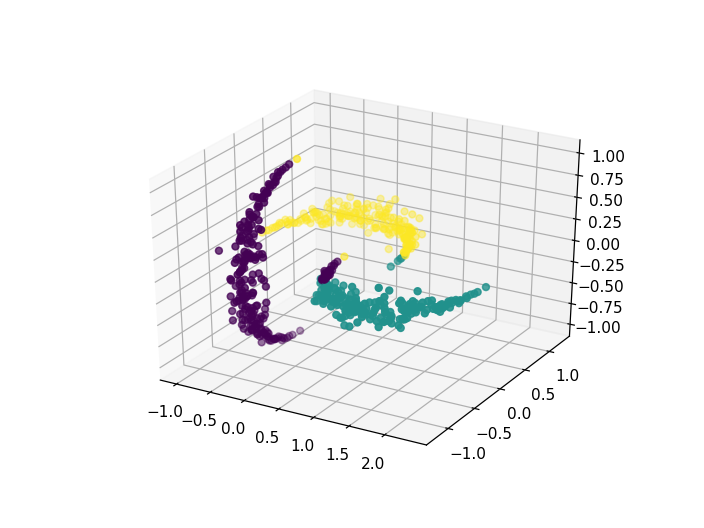

In [200]:
y_pred = MeanShift(0.6).fit_predict(X)


fig = plt.figure()
ax = fig.gca(projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_pred)
plt.show()

In [184]:
bandwidths[Ks <= 2]

array([0.46666667, 0.5       , 0.53333333, 0.56666667, 0.6       ,
       0.63333333, 0.66666667, 0.7       , 0.73333333, 0.76666667,
       0.8       , 0.86666667, 0.9       , 0.93333333, 0.96666667,
       1.        ])

<IPython.core.display.Javascript object>


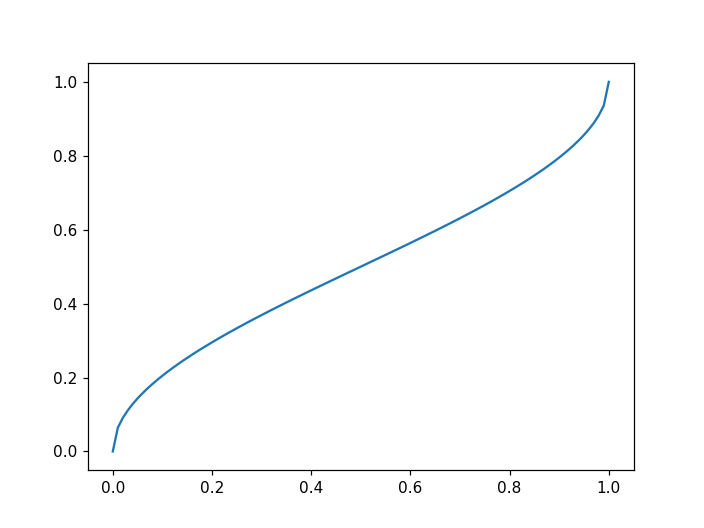

In [195]:
x = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
ax.plot(x, np.arccos(1 - 2 * x) / np.pi)
plt.show()

In [ ]:
np.a